In [1]:
import tensorflow as tf

tf.debugging.set_log_device_placement(True)
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten,BatchNormalization

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10774199944210458392
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4990763008
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7389770700254501790
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660, pci bus id: 0000:26:00.0, compute capability: 7.5"
]


In [8]:
# modeling(functional API)
input_shape = (224, 224, 3)  # 논문에서 제시된 shape
x = Input(shape = input_shape, name='INPUT')

# CONV
conv1 = Conv2D(filters=96, kernel_size=11, activation='relu', strides=4, name='CONV_1')(x)
pool1 = MaxPooling2D((3,3), strides=2, name='POOL_1')(conv1)  # overlapped pooling
# lrn1 = local_response_normalization(conv1,depth_radius=5, bias=2, alpha=0.0001, beta=0.75) 
lrn1 = BatchNormalization(name='LRN_1')(pool1)

conv2 = Conv2D(filters=256, kernel_size=5, activation='relu', strides=1, padding='same', name='CONV_2')(lrn1)
pool2 = MaxPooling2D((3,3), strides=2, name='POOL_2')(conv2)
# lrn2 = local_response_normalization(conv2,depth_radius=5, bias=2,  alpha=0.0001, beta=0.75)
lrn2 = BatchNormalization(name='LRN_2')(pool2)

conv3 = Conv2D(filters=384, kernel_size=3, activation='relu', strides=1, padding='same', name='CONV_3')(lrn2)
conv4 = Conv2D(filters=384, kernel_size=3, activation='relu', strides=1, padding='same', name='CONV_4')(conv3)
conv5 = Conv2D(filters=256, kernel_size=3, activation='relu', strides=1, padding='same', name='CONV_5')(conv4)
pool3 = MaxPooling2D((3,3), strides=2, name='POOL_3')(conv5)

# FC
f = Flatten()(pool3)
f = Dense(4096, activation='relu', name='FC_1')(f)
f = Dropout(0.5)(f)  # 논문 parameter 0.5 이용
f = Dense(4096, activation='relu', name='FC_2')(f)
f = Dropout(0.5)(f)
out = Dense(4, activation='softmax', name='OUTPUT')(f)

model = Model(inputs=x, outputs=out)
model.summary()

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
CONV_1 (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
POOL_1 (MaxPooling2D)        (None, 26, 26, 96)        0         
_________________________________________________________________
LRN_1 (BatchNormalization)   (None, 26, 26, 96)        384       
_________________________________________________________________
CONV_2 (Conv2D)              (None, 26, 26, 256)       614656    
_________________________________________________________________
POOL_2 (MaxPooling2D)        (N

In [9]:
from tensorflow.keras.optimizers import Adam
model.compile(loss='categorical_crossentropy',
                     optimizer=Adam(0.0001),
                     metrics=['accuracy'])

In [10]:
train_dir ='D:\\빅데이터기반지능형서비스개발\\07기업요구사항기반의문제해결pjt\\tdata\\train'
test_dir = 'D:\\빅데이터기반지능형서비스개발\\07기업요구사항기반의문제해결pjt\\tdata\\validation'

train_image_generator = ImageDataGenerator(rescale=1./255,shear_range=0.2,
                                          horizontal_flip=True,
                                           vertical_flip=True,
                                          width_shift_range=.2,height_shift_range=.2,
                                          fill_mode='nearest')
val_image_generator = ImageDataGenerator(rescale=1./255)
### augmentation : ImageDataGenerator( rescale = 1.0/255,shear_range=0.2,zoom_range=0.2)

train_data_gen = train_image_generator.flow_from_directory(batch_size=32,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(224, 224),
                                                           class_mode='categorical')

val_data_gen = val_image_generator.flow_from_directory(batch_size=32,
                                                         directory=test_dir,
                                                         target_size=(224, 224),
                                                         class_mode='categorical')

Found 20438 images belonging to 4 classes.
Found 3188 images belonging to 4 classes.


In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)
from tensorflow.keras.models import load_model

history = model.fit_generator(train_data_gen,
                                epochs=20,callbacks=[early_stopping],
                                validation_data=val_data_gen,
                              shuffle=True)

model.save("logs/new_1.h5")

  ...
    to  
  ['...']
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
  ...
    to  
  ['...']
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Train for 639 steps, validate for 100 steps
Epoch 1/20
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:

Epoch 7/20
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
638/639 [============================>.] - ETA: 0s - loss: 0.7393 - accuracy: 0.6774Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
639/639 [==============================] - 217s 339ms/step - loss: 0.7395 - accuracy: 0.6773 - val_loss: 1.1254 - val_accuracy: 0.5047
Epoch 8/20
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
638/639 [============================>.] - ETA: 0s - loss: 0.7224 - accuracy: 0.6845Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
639/639 [======

In [13]:
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_dir = 'D:\\빅데이터기반지능형서비스개발\\07기업요구사항기반의문제해결pjt\\tdata\\test'

tst_image_generator = ImageDataGenerator(rescale=1./255)

tst_data_gen = tst_image_generator.flow_from_directory(batch_size=32,
                                                         directory=test_dir,
                                                         target_size=(224, 224),
                                                         class_mode='categorical',
                                                      shuffle=False)

Found 1819 images belonging to 4 classes.


In [28]:
dd = model.evaluate_generator(tst_data_gen,32)
dd

  ...
    to  
  ['...']
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0


[1.1016732417047024, 0.5107422]

In [15]:
tst_data_gen.reset()
Y_pred = model.predict_generator(tst_data_gen)#validation_generator.n // validation_generator.batch_size+1)
import numpy as np

y_pred = np.argmax(Y_pred, axis=1) 

cm=confusion_matrix(tst_data_gen.classes, y_pred)
tot=np.sum(cm,axis=1)
cm1=cm/tot[:,None]
cm1

Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0


array([[0.71052632, 0.28947368, 0.        , 0.        ],
       [0.13744076, 0.54344392, 0.25276461, 0.06635071],
       [0.0497449 , 0.21811224, 0.39795918, 0.33418367],
       [0.01840491, 0.02147239, 0.21165644, 0.74846626]])

In [18]:
classes=['0','1','2','3']

In [19]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')

<AxesSubplot:>

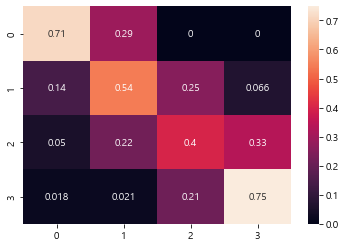

In [22]:
df_cm = pd.DataFrame(cm1,
                     index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure()
sn.heatmap(df_cm, annot=True)